# Project: 뉴스기사 요약

**두 가지 요약 진행**
1. 추상적 요약
2. 추출적 요약

### 데이터 수집하기
- 데이터 다운로드

In [12]:
import os
import pandas as pd

data = pd.read_csv(os.getenv("HOME")+"/aiffel/news_summarization/data/news_summary_more.csv")    
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


In [13]:
data.sample(10)

,headlines,text
86847,"Das retires, Tapan Ray to be Economic Affairs ...",Shaktikanta Das retired on Wednesday after 37 ...
2265,"Mumbai Ola, Uber drivers threaten strike amid ...",Mumbai Ola and Uber drivers have threatened to...
66118,Mumbai railway station lit up in pink for 'Day...,Mumbaiâs Chhatrapati Shivaji Maharaj Terminu...
5030,Real Madrid beat Al Ain 4-1 to win record 4th ...,Three-time defending Champions League champion...
73851,Former cricketer arrested for duping young cri...,"A 29-year-old former state-level cricketer, Sa..."
66688,Twitter is enslaved to US politics: WikiLeaks ...,Micro-blogging site Twitter is enslaved to its...
66792,PM Modi attends India's opening match at FIFA ...,PM Narendra Modi attended India's first match ...
21070,"Celebrities wish Priyanka, Nick on their roka ...","Bollywood celebrities, including Preity Zinta ..."
55758,Uber driver held over killing of British diplo...,Authorities in Lebanon have arrested an Uber d...
95648,BCCI confirms Virat Kohli to miss start of IPL 10,BCCI has confirmed Virat Kohli will miss the s...


**추상적 요약(Abstractive Summarization)**
- text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델 학습 가능  
    
**추출적 요약(Extractive Summarization)**
- 오직 text열만 사용

## Step 1. 추상적 요약(Abstractive Summarization)

### 1. 데이터 전처리하기_데이터 정리하기

- 실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 
- 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해보세요.

- NLTK의 불용어(stopwords)
    - NLTK(Natural Language Toolkit)
    - 영어 기호, 통계, 자연어 처리를 위한 라이브러리
    - I, my, me, over, 조사, 접미사 와 같이 문장에는 자주 등장하지만 요약에 의미가 없는 100여개의 불용어가 미리 정리되어 있음

In [14]:
# !pip install nltk
# !pip install beautifulsoup4 / 문서를 파싱하는데 사용하는 패키지

In [15]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/aiffel0042/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**중복 샘플과 NULL값 샘플 제거**

In [16]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


**중복 샘플 제거**
- drop_duplicate()

In [17]:
data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


**NULL 값 확인**
- .isnull().sum()
    

In [18]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


- NULL 값 모두 0
- 만약 NULL 값이 존재할 경우
    - dropna() 사용

**텍스트 정규화**
- 단어 중에 같은 의미이지만 다른 표현으로 쓰인 경우들이 있음
    - it'll = it will 
    - 기계가 다른 언어로 간주하여 연산량을 늘리는 것보다 기계학습 전에 미리 같은 표현으로 통일
- 이러한 방법론: **텍스트 정규화(text normalization)** 

In [19]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


**불용어(stopwords)**
- 일반적으로 텍스트에는 자주 등장하지만 자연어 처리를 할 때 실질적으로 별 도움이 되지 않는 단어들
- 불용어 제거는 자연어 처리의 성능을 높이는 방법
- NLTK에서 제공하는 불용어 리스트를 참조하여 샘플에서 불용어 제거

In [20]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

- text 전처리 시에서만 불용어 제거 호출
- headlines 전처리 시에는 불용어 제거하지 않음
    - Abstractive한 문장 요약 결과문이 자연스러운 문장이 되려면 불용어들이 **headlines**에는 남아 있는게 더 좋음

In [210]:
#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z.]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

- 전처리 전, 후의 결과를 확인하기 위해 임의의 text와 headlines을 만들어 함수 호출

In [211]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headlines = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_headlines, False))  # 불용어를 제거하지 않습니다.

everything bought great infact ordered twice third ordered wasfor mother father.
great way to start the day


**변환**
- 모든 알파벳 -> 소문자
- html 태그 제거
- 괄호로 묶인 단어 시퀀스 제거
- 특수문자 제거

- 훈련 데이터 전체에 대해서 전처리 수행
    - text의 경우 불용어를 제거
    - headlines의 경우 불용어 제거 하지 않음
    - 따로 호출해서 진행해야함

In [212]:
clean_text = []

# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

['aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical illnesses disability accidental death benefit rider life cover age years',
 'two minor cousins uttar pradesh gorakhpur allegedly repeatedly burnt tongs forced eat human excreta family friends two boys school cousins revealed ordeal police child welfare committee brought back gorakhpur nepal fled escape torture',
 'isha ghosh year old member bharat scouts guides imparting physical mental training schoolchildren jharkhand several decades chaibasa based ghosh reportedly walks seven kilometres daily spends eight hours conducting physical training apart climbing yoga sessions says one something society till one last breath',
 'days threatened step post congress mlas continue crossing line karnataka chief minister hd kumaraswamy accused taking potshots asked many days tolerate stuff kumaraswamy made statements congress mla demanded 

- headlines에 대해서 전처리 함수를 호출할 때, 불용어 제거를 수행하지 않음
- 두 번째 인자로 False -> celan_headlines.append(preprocess_sentence(s,False))

In [213]:
clean_headlines = []

# 전체 headlines 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

clean_headlines[:5]

['aegon life iterm insurance plan helps customers save tax',
 'up cousins fed human excreta for friendship with boys',
 'yr old woman conducts physical training in khand schools',
 'how long can tolerate congress leaders potshots taka cm',
 'odisha cm patnaik controls mining mafia union minister']

In [214]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

**.isnull().sum()을 사용해서 Null 값이 생겼는지 확인**

In [215]:
data.isnull().sum()

headlines         0
text              0
decoder_input     0
decoder_target    0
dtype: int64

- headlines 열에서 0개 NULL 값 생김

### 2. 데이터 전처리하기_훈련데이터와 테스트데이터 나누기

**샘플의 최대 길이 정하기**
- Text와 Summary의 최소, 최대, 평균 길이를 구하고 또한 길이 분포 시각화

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 50
텍스트의 평균 길이 : 35.17023185700955
요약의 최소 길이 : 1
요약의 최대 길이 : 9
요약의 평균 길이 : 8.317547196899001


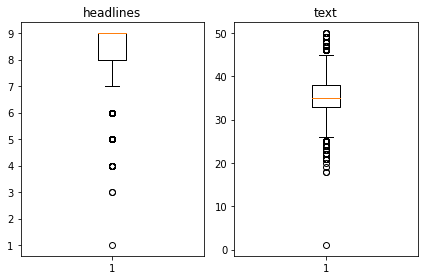

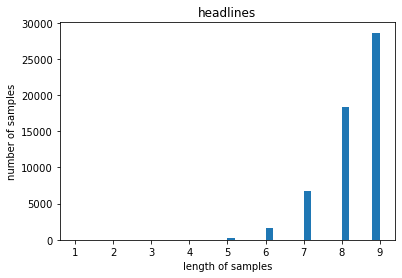

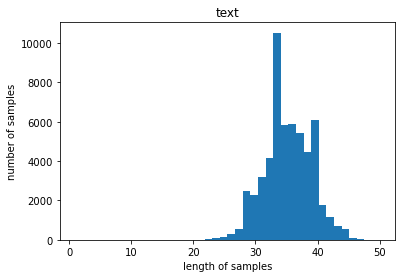

In [216]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

**text**    
- 최소 길이 : 1    
- 최대 길이 : 60    
- 평균 길이 : 35.09968483123221     
<br/>   

**headlines**    
- 최소 길이 : 1    
- 최대 길이 : 16    
- 평균 길이 : 9.299532330215534    
<br/>    
- 최소 & 최대 길이 차이가 많이 나지 않음

**text 최대 길이 & headlines 최대 길이 임의로 정하기**

In [217]:
text_max_len = 50
headlines_max_len = 9

**훈련 데이터와 샘플의 길이를 입력하여 데이터의 몇 %가 해당하는지 계산하는 함수를 만들어서 판단**

In [218]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [219]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 9 이하인 샘플의 비율: 1.0


**정해진 길이보다 길면 제외하는 방법으로 데이터 정제**

In [220]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 55724


- ```Step 2. 추출적 요약(Extractive Summarization) 데이터 사용 가능```
- ```Step 2. 진행 시 Step 2 아래로 이동```

**시작, 종료 토큰 추가하기**
- 디코더는 시작 토큰을 입력받아 문장을 생성하기 시작
- 종료 토큰을 예측한 순간 문장 생성을 멈춤
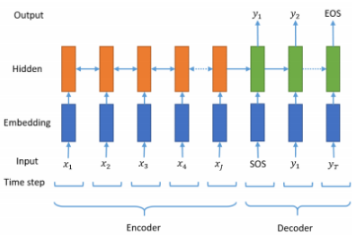
- seq2seq 훈련을 위해 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가할 필요가 있음
- 임의로 명명
    - 시작 토큰: sostoken
    - 종료 토큰: eostoken
    - 앞, 뒤로 추가
- 디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름
    - docoder_input
- 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름
    - decoder_target
- 두 개의 문장 모두 headlines 열로부터 만듦

In [76]:
#headlines 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
1,up cousins fed human excreta for friendship wi...,two minor cousins uttar pradesh gorakhpur alle...,sostoken up cousins fed human excreta for frie...,up cousins fed human excreta for friendship wi...
2,yr old woman conducts physical training in kha...,isha ghosh year old member bharat scouts guide...,sostoken yr old woman conducts physical traini...,yr old woman conducts physical training in kha...
3,how long can tolerate congress leaders potshot...,days threatened step post congress mlas contin...,sostoken how long can tolerate congress leader...,how long can tolerate congress leaders potshot...
4,odisha cm patnaik controls mining mafia union ...,union minister dharmendra pradhan wednesday cl...,sostoken odisha cm patnaik controls mining maf...,odisha cm patnaik controls mining mafia union ...


- 앞뒤로 토큰이 잘 붙음
- 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장

In [77]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

**훈련 데이터와 테스트 데이터 분리**
- 방법 두 가지
    1. 분리 패키지 사용
    2. 직접 코딩
- 직접 코딩 진행

**encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만듦**

In [78]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[53641 51071  1452 ... 15680 55282  5788]


**정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해주면 잘 섞인 샘플 데이터**

In [79]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

**섞인 데이터 8:2 비율로 분리**

In [80]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수:', n_of_val)

테스트 데이터의 수: 11144


**테스트 데이터의 갯수를 이용해 전체 데이터 양분**

In [81]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 44580
훈련 레이블의 개수 : 44580
테스트 데이터의 개수 : 11144
테스트 레이블의 개수 : 11144


### 3. 데이터 전처리하기_정수 인코딩

- 기계가 텍스트를 숫자로 처리할 수 있도록 훈련, 테스트 데이터의 단어들을 정수로 모두 바꿔줌
- 각 단어에 고유한 정수를 맵핑 작업 필요
- 이 과정을 **단어 집합(Vocaburary)**을 만든다고 표현
- 훈련 데이터에 대해서 단어 집합 만들기
- ```encoder_input_train```에 대해서 단어 집합 만들기

**Keras의 토크나이저를 사용**
- 입력된 훈련 데이터로부터 단어 집합 만들 수 있음

In [82]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

- 단어 집합이 생성되는 동시에 각 단어에 고유 정수가 부여됨
- 현재 생성된 단어 집합은 ```src_tokenizer.word_index```에 저장되어 있음
- 이렇게 만든 단어 집합에 있는 모든 단어를 사용하는 것이 아니라, 빈도수 낮은 단어들은 훈련 데이터에서 제외하고 진행

- 빈도수 7회 미만 단어들의 비중 차지 확인
- ```src_tokenizer.word_counts.items()```에는 단어와 각 단어의 등장 빈도수가 저장되어 있음
- 이를 통해 통계적인 정보를 얻을 수 있음

In [83]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 56683
등장 빈도가 6번 이하인 희귀 단어의 수: 39537
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 17146
단어 집합에서 희귀 단어의 비율: 69.75107174990738
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.151546260936435


- 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 뺌
- 훈련 데이터에서 제거
- 이를 제외한 단어 집합의 크기를 22,130
    - 이와 비슷한 값으로 어림잡아 단어 집합의 크기 20,000으로 제한
- 오크나이저를 정의할 때 num_words의 값을 정해주면, 단어 집합의 크기를 제한할 수 있음

In [84]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

- ```texts_to_sequences()```는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행
- 단어 집합의 크기 20,000으로 제한 
- 이제 20,000이 넘는 숫자들은 정수 인코딩 후에는 데이터 존재하지 않음

In [85]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[405, 60, 94, 7053, 1401, 226, 2558, 46, 78, 654, 8640, 298, 3906, 2405, 60, 1328, 1695, 27, 2, 14915, 815, 10, 899, 8404, 27, 42, 408, 12635, 585, 2558, 20, 4007, 408, 12635, 6031, 1448, 1154], [8897, 476, 1984, 32, 10142, 28, 75, 4108, 982, 193, 42, 3572, 6471, 748, 287, 8897, 1080, 28, 1005, 9, 1, 8897, 1009, 4057, 1045, 78, 326, 631, 605], [943, 23, 346, 1818, 61, 2012, 166, 2125, 508, 3312, 229, 241, 229, 101, 8405, 23, 821, 1161, 486, 334, 8406, 4258, 1213, 126, 4730, 23, 774, 17147, 226, 8641, 4210, 15931, 907, 647, 753, 2747, 425, 17148]]


- 더 이상 텍스트 데이터가 아닌 정수    
<br/>   
- **headlines 데이터**에 대해서도 동일한 작업 수행
- Keras의 토크나이저를 사용하여 decoder_input_train을 입력으로 전체 단어 집합과 각 단어에 대한 빈도수 계산

In [86]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

- 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여됨
- 이는 ```tar_tokenizer.word_index```에 저장
- ```tar_tokenizer.word_counts.items()```에는 단어와 각 단어의 등장 빈도수가 저장
- 이를 통해 통계적인 정보를 얻고 등장 빈도수가 6회 미만인 단어의 비중을 확인

In [87]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 25145
등장 빈도가 5번 이하인 희귀 단어의 수: 17481
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 7664
단어 집합에서 희귀 단어의 비율: 69.52077947902168
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 8.001810495093366


- 단어들 모두 제거
- 10,440에서 어림잡아 10,000을 단어 집합 크기로 제한

In [88]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 38, 3176, 1909, 127, 5, 1299, 72, 5365, 604], [1, 3994, 378, 103, 522, 108, 3, 26], [1, 379, 496, 441, 30, 58, 5366, 324], [1, 8, 61, 11, 2216, 5, 18, 31, 105, 2346], [1, 908, 396, 425, 66, 201, 7666, 2347, 5367]]
target
decoder  [[38, 3176, 1909, 127, 5, 1299, 72, 5365, 604, 2], [3994, 378, 103, 522, 108, 3, 26, 2], [379, 496, 441, 30, 58, 5366, 324, 2], [8, 61, 11, 2216, 5, 18, 31, 105, 2346, 2], [908, 396, 425, 66, 201, 7666, 2347, 5367, 2]]


- 정수 인코딩 작업 끝   
<br/>    
- ```decoder_input_train```과 ```decoder_target_train```에서 더 이상 숫자 10,000이 넘는 숫자는 존재하지 않음
- 빈도수가 낮은 단어를 삭제하면서 빈도수가 낮은 단어로만 구성된 샘플들은 빈 샘플이 될 가능성 높음
- 이 현상은 길이가 상대적으로 길었던 원문(text)의 경우 문제가 별로 없겠지만, 평균 길이가 4밖에 되지 않았던 해드라인(headlines)의 경우 이 현상이 두드러졌을 가능성 높음    
<br/>    
- 해드라인에서 길이가 0이 된 샘플들의 인덱스를 받아 옴
- 주의할 점은 요약문인 ```decoder_input```에는 ```sostokien``` 또는 ```decoder_target```에는 ```eostoken```이 추가된 상태이고, 이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플수와 동일하게 매우 높으므로 단어 집합 제한에도 삭제 되지 않음
- 이제 길이가 0이 된 해드라인의 실제 길이는 1로 나옴
- 길이 0이 된 ```decoder_input```에는 ```sostoken```,```decoder_target```에는 ```eostoken```만 남아 있음    
<br/>   
- 훈련 데이터와 테스트 데이터에 대해서 해드라인의 길이가 1인 경우의 인덱스를 각각 ```drop_train```과 ```drop_test```에 라는 변수에 저장
- 이 샘플들 모두 삭제

In [89]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 44580
훈련 레이블의 개수 : 44580
테스트 데이터의 개수 : 11143
테스트 레이블의 개수 : 11143


**패딩하기**
- 텍스트 시퀀스를 정수 시퀀스로 변환했다면, 이제 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업을 해줘야 함
- 정해둔 최대 길이로 패딩
- 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이 맞춤

In [90]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = headlines_max_len, padding='post')

### 4. 모델 설계하기

In [91]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

- hidden state
    - LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터
    - 이 파라미터는 LSTM의 용량의 크기, 뉴론의 개수
- 인코더 LSTM은 총 3개의 층으로 구성해서 모델의 복잡도를 높임
- hidden state의 크기를 늘리는 것이 LSTM 층 1개의 용량을 늘린다면, 3개의 층을 사용하는 것은 모델의 용량을 늘린다고 볼 수 있음
- 3개의 층을 지나서 인코더로부터 나온 출력 벡터는 디코더로 보내줘야 함

**디코더 설계**

In [92]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

- LSTM의 입력을 정의
    - ```initial_state```의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어줘야 함

**디코더 출력층 설계**

In [93]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

- headlines의 단어장인 ```tar_vocab```의 수많은 선택지 중 하나의 단어를 선택하는 다중 클래스 분류 문제를 풀어야 함
- Dense의 인자로 ```tar_vocab```을 주고 활성화 함수로 소프트맥스 함수를 사용    
<br/>    
- 지금까지 설계한 것은 인코더의 hidden state와 cell state를 디코더의 초기 state로 사용하는 가장 기본적인 seq2seq
- 디코더의 출력층 **어텐션 매커니즘**을 통해 성능을 높일 수 있음

### 5. 어텐션 메커니즘 사용하기

- 어텐션 매커니즘을 수행하는 어텐션 함수를 설계하는 것은 또 다른 새로운 신경망을 설계해야한다는 뜻
- 이미 구현된 어텐션 함수를 가져와서 디코더의 출력층에 어떤 방식으로 결합하는지 배워볼 에정

**아래 코드를 수행하여 깃허브에 공개된 어텐션 함수를 다운**

In [94]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

**설계한 디코더의 출력을 수정**

In [95]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

- 위 코드는 인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용
- 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동

### 6. 모델 훈련하기
- 설계한 모델을 가지고 훈련 진행

In [97]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
175/175 [==============================] - 60s 346ms/step - loss: 6.6865 - val_loss: 6.2193
Epoch 2/50
175/175 [==============================] - 56s 323ms/step - loss: 6.1694 - val_loss: 5.9634
Epoch 3/50
175/175 [==============================] - 56s 322ms/step - loss: 5.8676 - val_loss: 5.7146
Epoch 4/50
175/175 [==============================] - 56s 322ms/step - loss: 5.5843 - val_loss: 5.5327
Epoch 5/50
175/175 [==============================] - 56s 322ms/step - loss: 5.3450 - val_loss: 5.3388
Epoch 6/50
175/175 [==============================] - 57s 323ms/step - loss: 5.1325 - val_loss: 5.2146
Epoch 7/50
175/175 [==============================] - 56s 323ms/step - loss: 4.9382 - val_loss: 5.1242
Epoch 8/50
175/175 [==============================] - 57s 323ms/step - loss: 4.7685 - val_loss: 5.0080
Epoch 9/50
175/175 [==============================] - 56s 323ms/step - loss: 4.6108 - val_loss: 4.9266
Epoch 10/50
175/175 [==============================] - 56s 323ms/step - l

- ```EarlyStopping```: 조기 종료
    - 특정 조건이 충족되면 모델의 훈련을 멈추는 역할
    - ```val_loss(검증 데이터의 손실)```을 모니터링 하면서
    - 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 ```patiensce=2``` 2회 관측되면 학습 중단

**훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정 시각화**

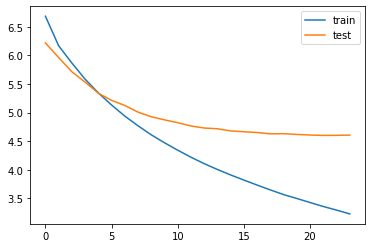

In [98]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 7. 인퍼런스 모델 구하기

**테스트 단계**
- 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원
- 필요한 3개의 사전을 아래와 같이 미리 준비

In [99]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

- seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야함
- 훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한번에 비교할 수 있음
- 인코더와 디코더를 엮은 통짜 모델 하나만 준비
- 인퍼런스를 위한 모델 설계를 별도로 함
- 이때는 인코더 모델과 디코더 모델을 분리해서 설계합니다.

In [100]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

**어텐션 매커니즘을 사용하는 출력층을 설계해야 함**

In [101]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

**인퍼런스 단계에서 단어 시퀀스를 완성하는 함수 만들기**

In [102]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

### 8. 모델 테스트하기

- 테스트 단계에서는 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인
- 주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수 만들기
- 함수를 만들 때, Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외
- headlines의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외

In [103]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

### 9. 실제 결과와 요약문 비교하기

In [113]:
for i in range(0, 50):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : simran writer apurva asrani facebook post alleged kangana ranaut lying co writing script asrani claiming wrote nine drafts script said told kangana turning director demanding co writer credit film first cut added eventually agreed give kangana additional writing credit 
실제 요약 : simran writer says kangana lied about co writing script 
예측 요약 :  casting director denies casting casting director


원문 : cybersecurity expert john mcafee said banks india cracking accounts connected crypto exchanges causing dip also asked cryptocurrency investors panic reports top indian banks suspended accounts country top exchanges added distributed exchanges months away impossible crack 
실제 요약 : crypto falling due to indian crackdown on exchanges mcafee 
예측 요약 :  mcafee cryptocurrency exchange hacked to cryptocurrency cryptocurrency


원문 : central information commission rejected rti query expenses incurred bjp president amit shah security cited rti act exemption clauses personal information safety rejec

예측 요약 :  man who is the gunpoint in us


원문 : exercise classes teaching colombian dance style banned iran religious authorities declared dance islamic ideology move came amid fears dance style might encourage revealing clothing mixing iran made similar announcements sports especially women past 
실제 요약 : iran bans classes for being un islamic 
예측 요약 :  why is the children celebrated in the day


원문 : prize first ever wimbledon began years ago july guinea trophy prize money wimbledon year million singles champions receiving million total men paid entrance fee first tournament featured singles event 
실제 요약 : st wimbledon prize was guinea trophy now its cr 
예측 요약 :  nadal federer to be million in


원문 : pakistan released abdul ghani one co founders afghan taliban militant group said second command afghan taliban coordinated militant group operations southern afghanistan release comes amid peace talks us taliban end year old war afghanistan 
실제 요약 : pakistan releases afghan taliban co found

예측 요약 :  students tops jee advanced exam


원문 : talking billionaire elon musk led electric car maker tesla american investor jim said company headed brick wall also said short tesla lost money know company stock decline tesla stock price fall company fall added 
실제 요약 : tesla headed for wall investor jim 
예측 요약 :  tesla tesla tesla is tesla model tesla


원문 : bjp mp laxmi narayan yadav said many people dubious received country highest civilian award bharat ratna earlier many given award said trend bharat ratna changed given dr br ambedkar added 
실제 요약 : people with got bharat ratna bjp mp 
예측 요약 :  bjp mp seeks land for land ratna


원문 : cartoon sitcom simpsons released short animated video us president donald trump first days office clip shows trump bed white house counting president like increasing twitter following video also trump daughter ivanka taking justice ruth seat supreme court 
실제 요약 : the simpsons releases video on trump first days 
예측 요약 :  video trump calls trump for whi

- 잘된 요약문들이 있음
    - 원문에 없던 단어를 사용해서 요약한 경우
- 잘 안된 요약문들도 있음
    - **개선 사항**
    - seq2seq와 어텐션의 자체의 조합을 좀 더 좋게 수정
    - 빔 서치(beam search)
    - 사전 훈련된 워드 임베딩(pre-trained word embedding)
    - 인코더 - 디코더 자체의 구조 새로이 변경하는 트랜스포머(transformer)

## Step 2. 추출적 요약(Extractive Summarization)

- 앞에서 seq2seq를 통해 추상적 요약 진행
- 추출적 요약도 있음
    - 이미 본문에 존재하는 단어구, 문장을 뽑아서 요약으로 삼음
- 패키지 ```Summa```에서는 추출적 요약을 위한 모듈인 summarize를 제공

### 0. 패키지 설치

In [245]:
# pip install summa

### 1. 데이터

In [246]:
# import pandas as pd
# import os

# data_1 = pd.read_csv(os.getenv("HOME")+"/aiffel/news_summarization/data/news_summary_more.csv")    
# print('전체 샘플수 :', (len(data_1)))

**전처리한 데이터대상으로 인덱스 정리**

In [247]:
data.reset_index(drop=True, inplace=True)

In [248]:
data

,headlines,text,decoder_input,decoder_target
0,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
1,up cousins fed human excreta for friendship wi...,two minor cousins uttar pradesh gorakhpur alle...,sostoken up cousins fed human excreta for frie...,up cousins fed human excreta for friendship wi...
2,yr old woman conducts physical training in kha...,isha ghosh year old member bharat scouts guide...,sostoken yr old woman conducts physical traini...,yr old woman conducts physical training in kha...
3,how long can tolerate congress leaders potshot...,days threatened step post congress mlas contin...,sostoken how long can tolerate congress leader...,how long can tolerate congress leaders potshot...
4,odisha cm patnaik controls mining mafia union ...,union minister dharmendra pradhan wednesday cl...,sostoken odisha cm patnaik controls mining maf...,odisha cm patnaik controls mining mafia union ...
...,...,...,...,...
55719,kashmiri separatist leaders summoned over mone...,enforcement directorate summoned jammu kashmir...,sostoken kashmiri separatist leaders summoned ...,kashmiri separatist leaders summoned over mone...
55720,pakistan starts building fence along afghanist...,pakistan started building nearly kilometer fen...,sostoken pakistan starts building fence along ...,pakistan starts building fence along afghanist...
55721,crpf jawan axed to death by maoists in chhatti...,crpf jawan tuesday axed death sharp edged weap...,sostoken crpf jawan axed to death by maoists i...,crpf jawan axed to death by maoists in chhatti...
55722,the matrix film to get reboot reports,according reports new version science fiction ...,sostoken the matrix film to get reboot reports,the matrix film to get reboot reports eostoken


In [249]:
data_1 = data['text']
print(data_1)

0        aegon life iterm insurance plan customers enjo...
1        two minor cousins uttar pradesh gorakhpur alle...
2        isha ghosh year old member bharat scouts guide...
3        days threatened step post congress mlas contin...
4        union minister dharmendra pradhan wednesday cl...
                               ...                        
55719    enforcement directorate summoned jammu kashmir...
55720    pakistan started building nearly kilometer fen...
55721    crpf jawan tuesday axed death sharp edged weap...
55722    according reports new version science fiction ...
55723    madhesi morcha alliance seven political partie...
Name: text, Length: 55724, dtype: object


In [250]:
from summa.summarizer import summarize

In [251]:
data_1.head(5)

0    aegon life iterm insurance plan customers enjo...
1    two minor cousins uttar pradesh gorakhpur alle...
2    isha ghosh year old member bharat scouts guide...
3    days threatened step post congress mlas contin...
4    union minister dharmendra pradhan wednesday cl...
Name: text, dtype: object

In [252]:
# 데이터가 매우 많은 관계로 50번까지만 진행
for i in range(0, 50):
  print(i+1,'번 문서')
  print('원문 :',data_1.loc[i])
  print('')
  print('요약 :',summarize(data_1.loc[i], ratio=0.35))
  print('')

1 번 문서
원문 : aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical illnesses disability accidental death benefit rider life cover age years

요약 : 

2 번 문서
원문 : two minor cousins uttar pradesh gorakhpur allegedly repeatedly burnt tongs forced eat human excreta family friends two boys school cousins revealed ordeal police child welfare committee brought back gorakhpur nepal fled escape torture

요약 : 

3 번 문서
원문 : isha ghosh year old member bharat scouts guides imparting physical mental training schoolchildren jharkhand several decades chaibasa based ghosh reportedly walks seven kilometres daily spends eight hours conducting physical training apart climbing yoga sessions says one something society till one last breath

요약 : 

4 번 문서
원문 : days threatened step post congress mlas continue crossing line karnataka chief minister hd kumaraswamy accused taking potshots asked many days tolerat

---

### 로우데이터로 추출적 요약 진행해보기

In [253]:
import pandas as pd
import os

data_2 = pd.read_csv(os.getenv("HOME")+"/aiffel/news_summarization/data/news_summary_more.csv")    
print('전체 샘플수 :', (len(data_2)))

전체 샘플수 : 98401


In [254]:
data_2

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...
...,...,...
98396,CRPF jawan axed to death by Maoists in Chhatti...,A CRPF jawan was on Tuesday axed to death with...
98397,First song from Sonakshi Sinha's 'Noor' titled...,"'Uff Yeh', the first song from the Sonakshi Si..."
98398,'The Matrix' film to get a reboot: Reports,"According to reports, a new version of the 199..."
98399,Snoop Dogg aims gun at clown dressed as Trump ...,A new music video shows rapper Snoop Dogg aimi...


In [255]:
data_2 = data_2['text']

In [256]:
data_2.head(5)

0    Saurav Kant, an alumnus of upGrad and IIIT-B's...
1    Kunal Shah's credit card bill payment platform...
2    New Zealand defeated India by 8 wickets in the...
3    With Aegon Life iTerm Insurance plan, customer...
4    Speaking about the sexual harassment allegatio...
Name: text, dtype: object

In [272]:
print('첫 번째 행 데이터:',data_2.loc[0])
print('')
print('첫 번째 행 데이터 요약:', summarize(data_2.loc[0], ratio=0.5))

첫 번째 행 데이터: Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.

첫 번째 행 데이터 요약: upGrad's Online Power Learning has powered 3 lakh+ careers.


In [273]:
print('두 번째 행 데이터:',data_2.loc[1])
print('')
print('두 번째 행 데이터 요약:', summarize(data_2.loc[1], ratio=0.5))

두 번째 행 데이터: Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.

두 번째 행 데이터 요약: Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.


```summarize는 문장 구분을 '콤마' 기준으로 진행하여 요약함```
- 문장에 콤마가 없으면 실행되지 않음
- 한 문장이 아닌 여러문장이 있어야 사용 가능

In [174]:
# 데이터가 매우 많은 관계로 50번까지만 진행
for i in range(0, 50):
  print(i+1,'번 문서')
  print('원문 :',data_2.loc[i])
  print('')
  print('요약 :',summarize(data_2.loc[i], ratio=0.35))
  print('')

1 번 문서
원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.

요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.

2 번 문서
원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.

요약 : Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.

3 번 문서
원문 : New Zealand defeat

---

### 결과

**추상적 요약(abstractive summary)**

In [276]:
print("원문 :", seq2text(encoder_input_test[0]))
print("실제 요약 :", seq2headlines(decoder_input_test[0]))
print("예측 요약 :", decode_sequence(encoder_input_test[0].reshape(1, text_max_len)))

원문 : simran writer apurva asrani facebook post alleged kangana ranaut lying co writing script asrani claiming wrote nine drafts script said told kangana turning director demanding co writer credit film first cut added eventually agreed give kangana additional writing credit 
실제 요약 : simran writer says kangana lied about co writing script 
예측 요약 :  casting director denies casting casting director


**추출적 요약(extractive summary)**

In [275]:
  print('원문 :',data_2.loc[0])
  print('')
  print('요약 :',summarize(data_2.loc[0], ratio=0.35))
  print('')

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.

요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.



### 정리

**추상적 요약(abstractive summary)**
- 전처리 단계를 체계적으로 진행하여 원문에 없는 문장도 만들어 내용 요약을 진행함
- 기능이 좋음

<br/>    
**추출적 요약(extractive summary)**
- 데이터 전처리를 하여 콤마없이 한 문장을 뽑아낼 경우 인식이 불가능
- ```summarize```를 활용하여 **ratio**를 설정할 때, 콤마 기준으로 문장을 잘라내어 가져옴
- 요약이라고 보기 힘들며, 한 문장을 가져오는 형태로 그침